
# Introduction
This Python project delves into the intricate landscape of Netflix data to unveil compelling insights and trends. Through advanced data analysis techniques and Python libraries, our exploration encompasses viewer preferences, content trends, and geographical patterns within the Netflix platform. The findings from this analysis are instrumental in understanding audience behavior and guiding strategic decisions for content acquisition and production.


Embark on a captivating journey through Netflix's content ecosystem with this data analysis project. Our comprehensive exploration delves deep into a rich pool of data, illuminating the diverse array of offerings within Netflix's platform. From analyzing viewer preferences to uncovering content distribution and geographical nuances, this project offers a holistic understanding of Netflix's content landscape.

## Project Objectives
Conduct an in-depth analysis of Netflix data to unveil meaningful insights and trends.
Utilize Python libraries and data analysis techniques to explore viewer preferences, content trends, and geographical patterns.
Offer actionable insights to comprehend audience behavior and inform strategic decisions for content acquisition and production

## Data Description

- show_id: A unique identifier for each show (movie or TV show).
- type: The type of the show, which can be either "Movie" or "TV Show".
- title: The title or name of the show.
- director: The director of the show. Some entries might not have director information and are shown as NaN (Not a Number).
- cast: The list of actors in the show, separated by commas. Some entries might not have cast information and are shown as NaN.
- country: The country where the show was produced. Some entries might not have country information and are shown as NaN.
- date_added: The date the show was added to Netflix, typically in the format "Month Day, Year".
- release_year: The year the show was released.
- rating: The rating of the show, such as "PG-13", "TV-MA", etc., indicating the appropriate audience or content rating.
- duration: The duration of the show. For movies, this usually indicates the number of minutes (e.g., "90 min"); for TV shows, this usually indicates the number of seasons (e.g., "1 Season" or "2 Seasons").
- listed_in: The categories or genres of the show, separated by commas (e.g., "Documentaries").
- description: A brief description or summary of the show.
- month_added: The month extracted from date_add column
- month_name_added: The month extracted from date_add column
- year_added:  The year extracted from date_add column

# Initial Assessment and Data Quality
## Data Cleaning 

In [11]:

import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

dataset_netflix = pd.read_csv("netflix_titles.csv")
dataset_disney = pd.read_csv("disney_plus_titles.csv")

In [12]:
def dataset_observation(dataset):
    for i in dataset.columns:
        rate = dataset[i].isna().sum() / len(dataset) * 100
        if rate > 0: print('The missing rate of {} is {}'.format(i, round(rate, 2)))

In [13]:
title=['Netflix', 'Disney+']
for i, dataset in enumerate([dataset_netflix, dataset_disney]):
    print('-'*10 + title[i] + '-'*10)
    dataset_observation(dataset)
    print()
    dataset.info()
    print()

----------Netflix----------
The missing rate of director is 29.91
The missing rate of cast is 9.37
The missing rate of country is 9.44
The missing rate of date_added is 0.11
The missing rate of rating is 0.05
The missing rate of duration is 0.03

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB

----

### Clean the dataset¶
I don't think `director`, `cast` and `description` are useful for my analysis, so drop them at first.
The ratio of missing `country` is big, it can not be filled with other countries, so i decide to fill it with `Unknown`.
The ratio of missing `rating` and `duration` is low, so rows with missing `rating` and `duration` can be dropped.

### Data Processiong
The `date_added` is object type, convert it into date type is easier for analysis.
Movies or TV Shows may be collaborated with many countries. I assume that the first country is the main production country.

In [160]:
def dataset_processing(dataset):
    df = dataset.drop(['director', 'cast', 'description'], axis=1)
    df.country = df.country.fillna('Unknown')
    df.dropna(inplace = True)
    df.drop_duplicates(inplace=True)
    
    # convert date
    df.date_added = df.date_added.str.strip()
    df.date_added = pd.to_datetime(df.date_added)
    df['add_year'] = df.date_added.dt.year
    df['add_month'] = df.date_added.dt.month
    
    # assume the movies or tv shows are mainly created by first country
    df['main_country'] = df['country'].apply(lambda x : x.replace(' ,', ',').replace(', ', ',').split(',')[0])
    return df

# check, no null value in the dataset
print('-'*10 + title[0] + '-'*10)
netflix_df = dataset_processing(dataset_netflix)
print(netflix_df.info())
print()

print('-'*10 + title[1] + '-'*10)
disney_df = dataset_processing(dataset_disney)
print(disney_df.info())
print()

----------Netflix----------
<class 'pandas.core.frame.DataFrame'>
Index: 8790 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   show_id       8790 non-null   object        
 1   type          8790 non-null   object        
 2   title         8790 non-null   object        
 3   country       8790 non-null   object        
 4   date_added    8790 non-null   datetime64[ns]
 5   release_year  8790 non-null   int64         
 6   rating        8790 non-null   object        
 7   duration      8790 non-null   object        
 8   listed_in     8790 non-null   object        
 9   add_year      8790 non-null   int32         
 10  add_month     8790 non-null   int32         
 11  main_country  8790 non-null   object        
dtypes: datetime64[ns](1), int32(2), int64(1), object(8)
memory usage: 824.1+ KB
None

----------Disney+----------
<class 'pandas.core.frame.DataFrame'>
Index: 1444 entri

### Other reparation
For a better analysis and visualization. I set the color:
- Red -- for Netflix dataset
- Blue -- for Disney+ dataset
After obseving the ratio between the movie and tv show, split it for following analysis.

In [328]:
# red, white
net_color = ["#E50914", "#000000"]

# dark blue, light blue
dis_color = ['#113CCF', '#87CEFA']

# all color
all_color = [net_color, dis_color]

def select_type(df, ty):
    return df[df.type == ty]

netflix_movie = select_type(netflix_df, 'Movie')
netflix_tv = select_type(netflix_df, 'TV Show')

disney_movie = select_type(disney_df, 'Movie')
disney_tv = select_type(disney_df, 'TV Show')

# Data Exploration
## Categorical Variables

In this dataset, Netflix has 2 main content types, which are Movies and TV Series. There is different measurement in `duration` column between Movie and TV Show. For example movie is counted by minute while TV show is counted for season containing many espisodes. However, because we can't tranform the season into exact minute, I will analyze the distribution of size between the 2 types purely based on `type` column, not `duration`. This is the limitation of this dataset and analysis.

In [229]:
# Set def for movie and tv show distribution 
def data_type(df):
    type_df = df.groupby('type').type.count()
    r = round(type_df / len(df), 2)
    return pd.DataFrame(r).T

In [331]:
def q1_imageSet(rate_df, ax, title, color):
    # Bar chart setting
    ax.barh(rate_df.index, rate_df['Movie'], color=color[0])
    ax.barh(rate_df.index, rate_df['TV Show'], left=rate_df['Movie'], color=color[1])
    ax.set_xlim(0, 1)
    ax.set_xticks([])
    ax.set_yticks([])

    # Text setting
    for i in rate_df.index:
        # Set Movie type annotation
        ax.annotate(f"{int(rate_df['Movie'][i]*100)}%", xy=(rate_df['Movie']['type']/2, 0),
                   fontsize=40, fontweight='light', fontfamily='serif', color='white',va = 'center', ha='center')
        
        ax.annotate(f"Movie", xy=(rate_df['Movie']['type']/2, -0.25),
                   fontsize=15, fontweight='light', fontfamily='serif', color='white',va = 'center', ha='center')
       
        # Set TV show type annotation
        ax.annotate(f"{int(rate_df['TV Show'][i]*100)}%", xy=(rate_df['Movie']['type']+rate_df['TV Show']['type']/2, 0),
                   fontsize=40, fontweight='light', fontfamily='serif', color='white',va = 'center', ha='center')
        
        ax.annotate(f"TV Show", xy=(rate_df['Movie']['type']+rate_df['TV Show']['type']/2, -0.25),
                   fontsize=15, fontweight='light', fontfamily='serif', color='white',va = 'center', ha='center')

    # Display Setting
    for s in ['top', 'left', 'right', 'bottom']:
        ax.spines[s].set_visible(False)
    ax.legend(rate_df.index).set_visible(False)
    ax.set_title(title, fontweight='medium', color='black', loc='center')

    

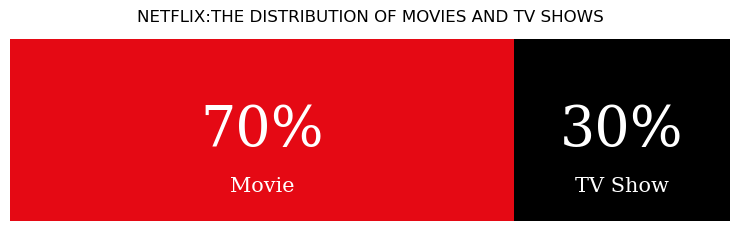

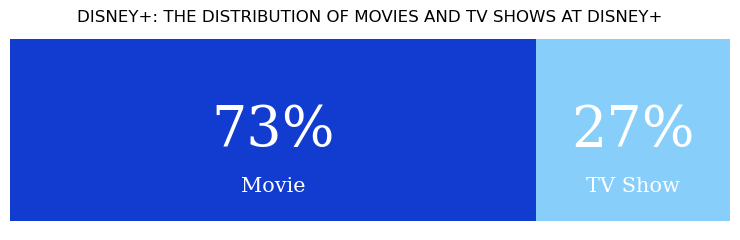

In [332]:
q1_title = ['NETFLIX:THE DISTRIBUTION OF MOVIES AND TV SHOWS', 'DISNEY+: THE DISTRIBUTION OF MOVIES AND TV SHOWS AT DISNEY+']
netflix_type = data_type(netflix_df)
disney_type = data_type(disney_df)

for i, df in enumerate([netflix_type, disney_type]):
    fig, ax = plt.subplots(figsize=(7.5, 2.5))
    q1_imageSet(df, ax, q1_title[i], all_color[i])
   
    plt.tight_layout()
    plt.show()

Both services have similar ratio between movies and tv shows, 7:3.

## The number of movie and tv show each year

In [351]:
def q2_imageSet(df, fig, ax, title, color):
    for i, year in enumerate(df['type'].value_counts().index):
        mtv_year = df[df['type']== year].date_added.dt.year.value_counts().sort_index()
        ax.plot(mtv_year.index, mtv_year, color[i], label=year, marker='o')
        plt.grid(True, linestyle= 'dotted')
        ax.set_facecolor('#696969')
        fig.patch.set_facecolor('#696969')
        ax.tick_params(axis='y', colors='white')
    
    
    # Set x-axis ticks
    minR = mtv_year.index.min()
    maxR = mtv_year.index.max()
    plt.xticks(np.arange(minR, maxR + 1, 3), rotation=35, color='white')

    # Add labels for each point
    for line in ax.lines:
        for x, y in zip(line.get_xdata(), line.get_ydata()):
            label = "{:.0f}".format(y)
            ax.annotate(label, (x, y), textcoords="offset points", xytext=(0, 5),
                       ha="right", color="white")

   
    for s in ['top', 'right', 'bottom', 'left']:
        ax.spines[s].set_visible(False)
    # Text Setting    
    ax.set_xlim(minR, maxR)
    ax.set_ylabel('Number of Entries', color='white')
    ax.set_xlabel('Year', color='white')
   
    ax.set_title(title, fontsize=14, color='white')
    fig.text(0.39,0.7,"Movie", fontweight="bold", fontfamily='serif', fontsize=15, color=color[0])
    fig.text(0.47,0.7,"|", fontweight="bold", fontfamily='serif', fontsize=15, color='white')
    fig.text(0.49,0.7,"Tv Show", fontweight="bold", fontfamily='serif', fontsize=15, color=color[1])
 

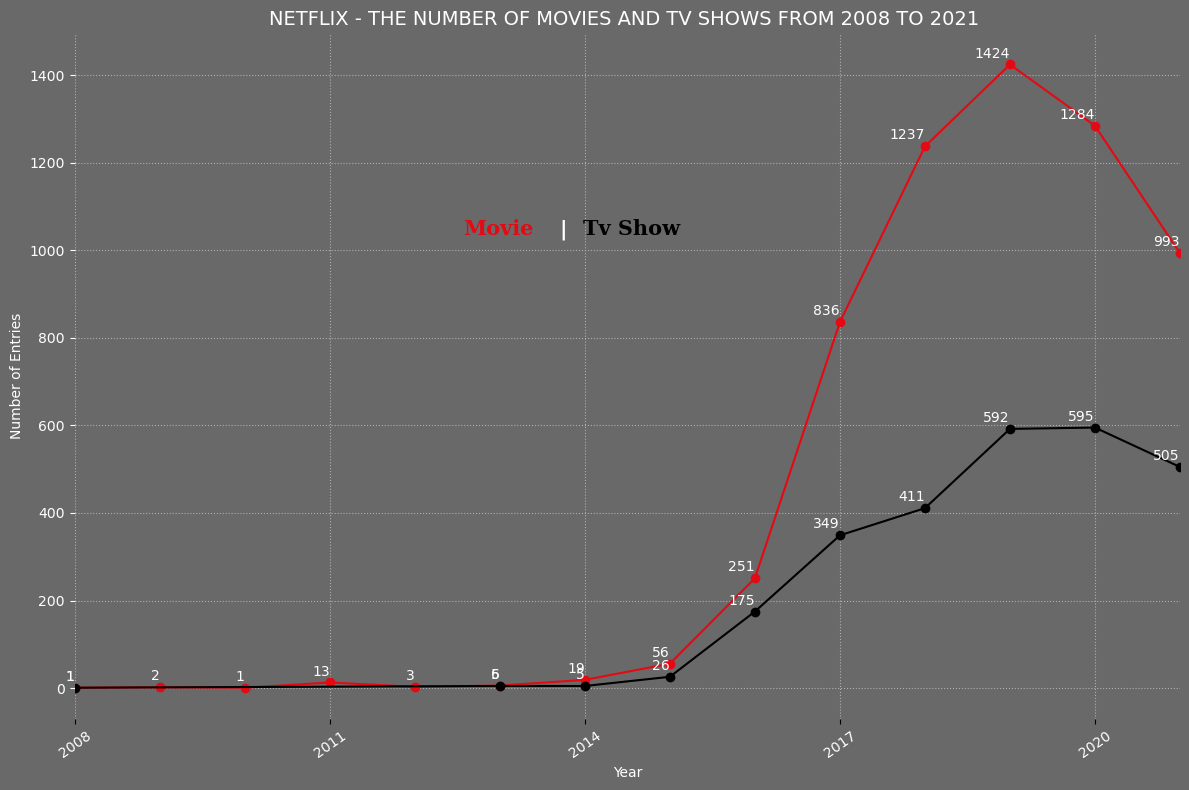

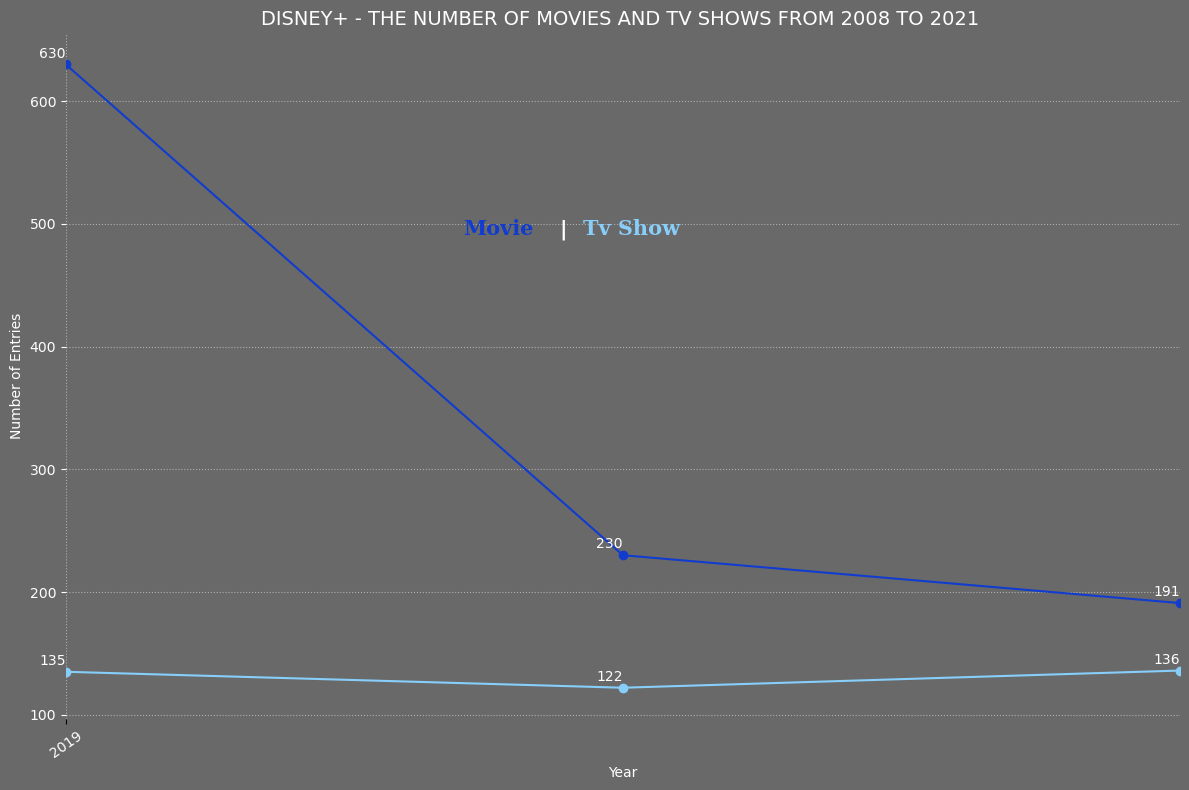

In [352]:
q2_title = ['NETFLIX - THE NUMBER OF MOVIES AND TV SHOWS FROM 2008 TO 2021 ', 'DISNEY+ - THE NUMBER OF MOVIES AND TV SHOWS FROM 2008 TO 2021 ']
for i, df in enumerate([netflix_df, disney_df]):
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    q2_imageSet(df, fig, ax, q2_title[i], all_color[i])
    
    plt.tight_layout()
    plt.show()

These figures also show when the online services start. Netflix is around 2008, and Disney+ is at 2019. (According to wiki, netflix started at 2007)

Netflix: The number of movies and tv shows are significantly increase from 2016 to 2020. After 2020, the numbers are decrease because data only collected until mid-2021.
Disney+: They add a lot of movies in their first year, but the number decreased significantly afterward. Conversely, the number of TV Shows remain stable, but is very low.
Netflix has more options for users.



In [378]:
def q3_imageSet(data, ax, title, color):
    color_map = [color[1] for _ in range(10)]
    color_map[0] = color_map[1] = color_map[2] =  color[0]
    sns.barplot(x=data.index, y=data.values, ax=ax, 
            palette=color_map)
    
    ax.set_facecolor('#696969')
    fig.patch.set_facecolor('#696969')
    # show the values
    offset = data.max() * 0.05
    for i, value in enumerate(data.values):
        ax.annotate(f"{data[i]}", xy=(i, value+offset), va='center', 
                    ha='center', fontweight='light', fontfamily='serif', color='white')

    ax.set_title(title, color='white')
    for s in ['top', 'left', 'right']:
        ax.spines[s].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xlabel('')

    # set grid line to make figure more pretty
    ax.grid(axis='y', linestyle='-', alpha=0.5, color='white')
    ax.set_axisbelow(True)

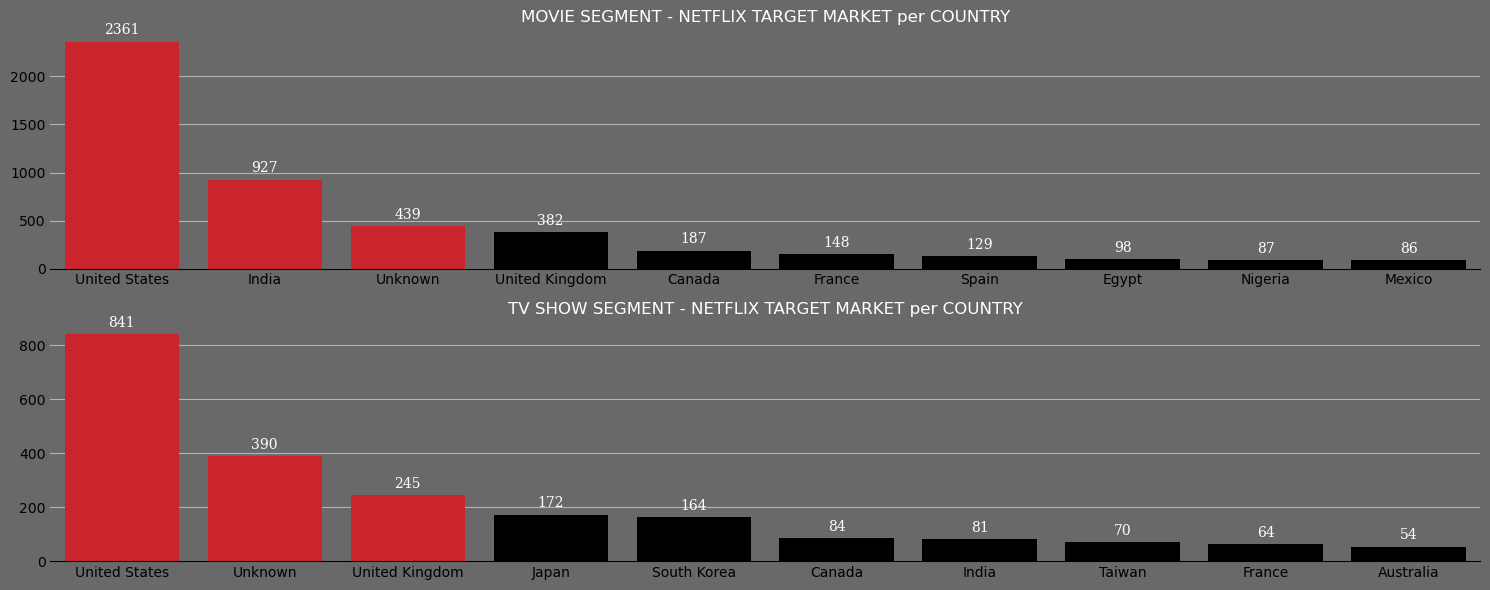

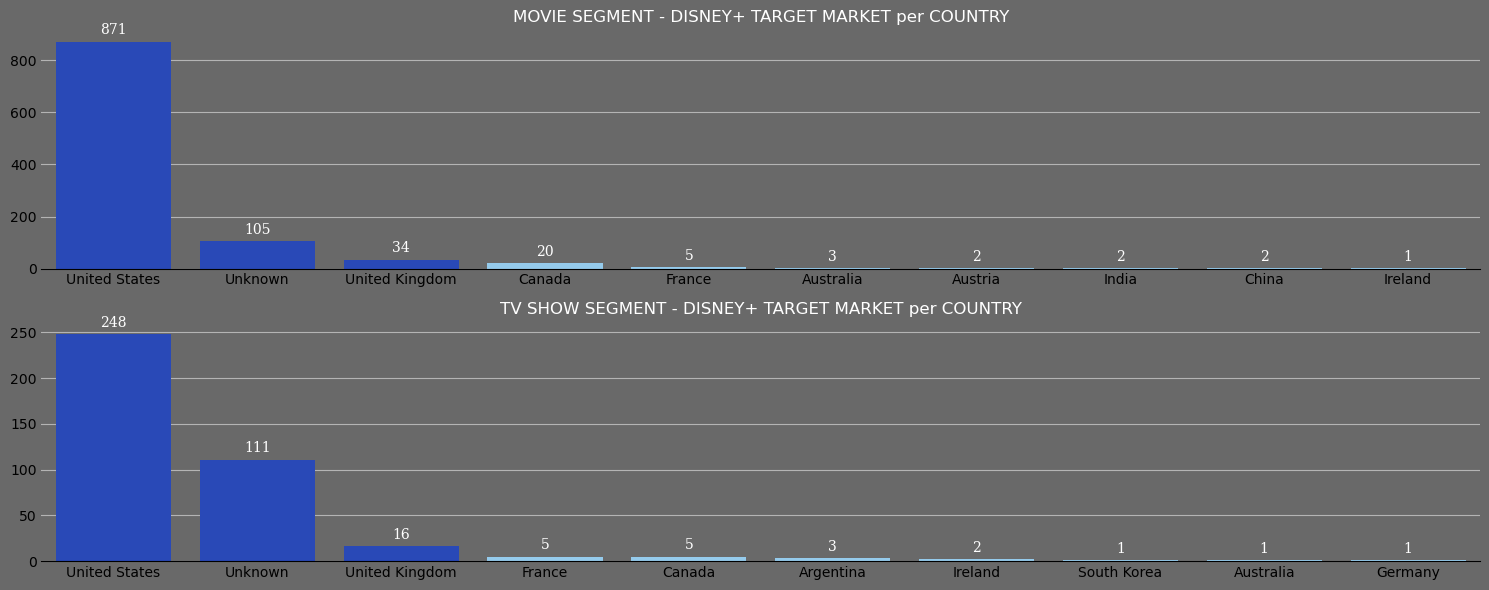

In [398]:
q3_title = [('MOVIE SEGMENT - NETFLIX TARGET MARKET per COUNTRY', 'TV SHOW SEGMENT - NETFLIX TARGET MARKET per COUNTRY')
           , ('MOVIE SEGMENT - DISNEY+ TARGET MARKET per COUNTRY', 'TV SHOW SEGMENT - DISNEY+ TARGET MARKET per COUNTRY')]
for i, data in enumerate([(netflix_movie, netflix_tv), (disney_movie, disney_tv)]):
    movie, tv = data[0], data[1]
    movie_df = movie.main_country.value_counts()[:10]
    tv_df = tv.main_country.value_counts()[:10]
    fig, ax = plt.subplots(2, 1, figsize=(15, 6))
    
    q3_imageSet(movie_df, ax[0], q3_title[i][0], all_color[i])
    q3_imageSet(tv_df, ax[1], q3_title[i][1], all_color[i])
    plt.tight_layout()
    plt.show()

In [381]:
def q4_processing(data):
    return data.groupby('release_year').agg(cnt=('show_id', 'count')).reset_index() \
    .sort_values(by='release_year', ascending=False)[:10]

In [394]:
def q4_imageSet(data, ax, title, color):
    img = sns.barplot(x='release_year', y='cnt', data=data, ax=ax, color=color)
    ax.set_facecolor('#696969')
    fig.patch.set_facecolor('#696969')
    ax.set_title(title, color='white')
    ax.set_xlabel('', color='white')
    ax.set_ylabel('', color='white')
    ax.grid(axis='y', linestyle='dotted', alpha=0.5, color='white')
    for s in ['top', 'right']:
        ax.spines[s].set_visible(False)
    ax.bar_label(img.containers[0], label_type='center', color='white', fontsize=16)

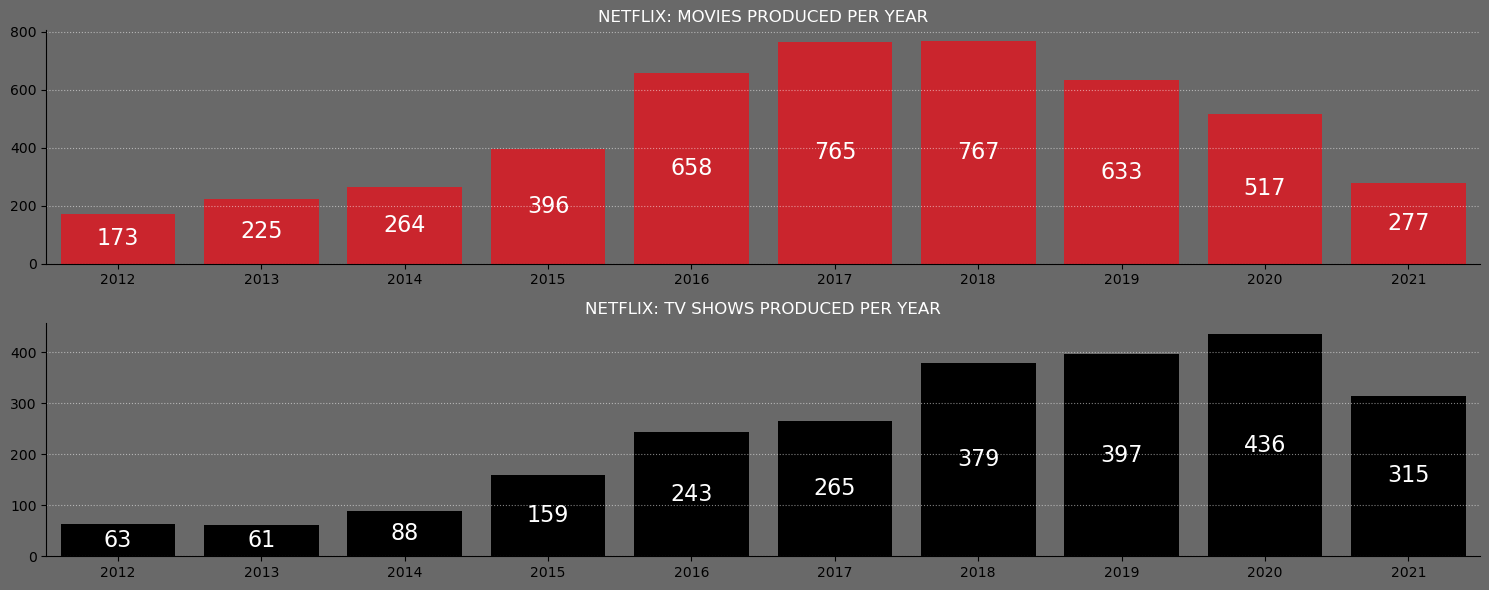

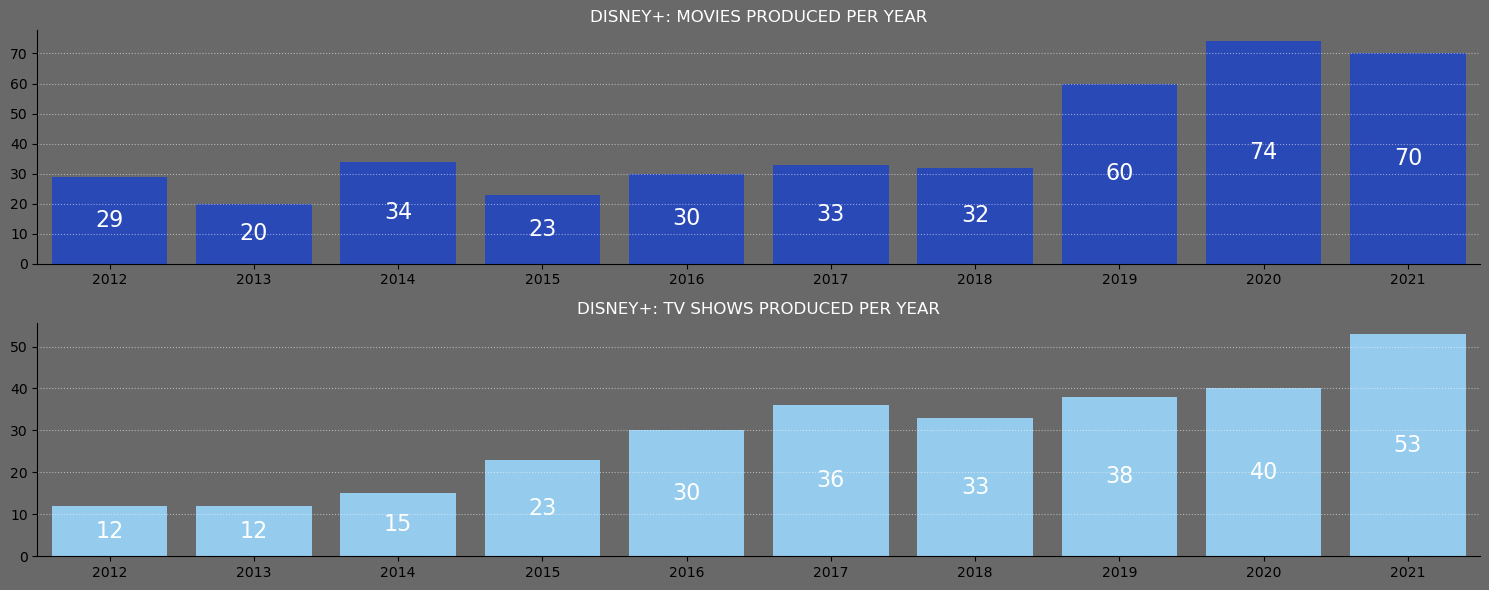

In [396]:
# clean the data
q4_title = [('NETFLIX: MOVIES PRODUCED PER YEAR', 'NETFLIX: TV SHOWS PRODUCED PER YEAR')
           , ('DISNEY+: MOVIES PRODUCED PER YEAR', 'DISNEY+: TV SHOWS PRODUCED PER YEAR')]
for i, data in enumerate([(net_movie, net_tv), (dis_movie, dis_tv)]):
    movie, tv = data[0], data[1]
    movie_df = q4_processing(movie)
    tv_df = q4_processing(tv)

    # create the image
    fig, ax = plt.subplots(2, 1, figsize=(15, 6))
    q4_imageSet(movie_df, ax[0], q4_title[i][0], all_color[i][0])
    q4_imageSet(tv_df, ax[1], q4_title[i][1], all_color[i][1])
    plt.tight_layout()
    plt.show()

In [397]:
def add_miss(ori_df, df):
    ori = ori_df.rating.value_counts().index
    missing = set(ori) - set(df.index)
    for i in missing: df[i] = 0
    return df[list(ori)] 

In [403]:
def q6_imageSet(rate_movie_df, rate_tv_df, ax, title, color):
    sns.barplot(x=rate_movie_df.index, y=rate_movie_df.values, color=color[0], width=0.5)
    sns.barplot(x=rate_tv_df.index, y=rate_tv_df.values, color=color[1], width=0.5)
    ax.set_facecolor('#696969')
    fig.patch.set_facecolor('#696969')

    # show the value
    offset = max(rate_movie_df.max(), rate_tv_df.abs().max()) * 0.05
    for i, value in enumerate(rate_movie_df.values):
        ax.annotate(f"{value}", xy=(i, value + offset), va='center', ha='center',fontweight='light', 
                    fontfamily='serif', color='white')
    for i, value in enumerate(rate_tv_df.values):
        ax.annotate(f"{-1 * value}", xy=(i, value - offset), va='center', ha='center',
                    fontweight='light', fontfamily='serif', color='white')

    # set the figure background
    for s in ['top', 'left', 'right', 'bottom']:
        ax.spines[s].set_visible(False)
        
    ax.set_xlabel('')
    ax.tick_params(axis='both', length=0, color='white')
    ax.set_title(title, color='white')
    ax.set_yticks([])
    #plt.tight_layout()

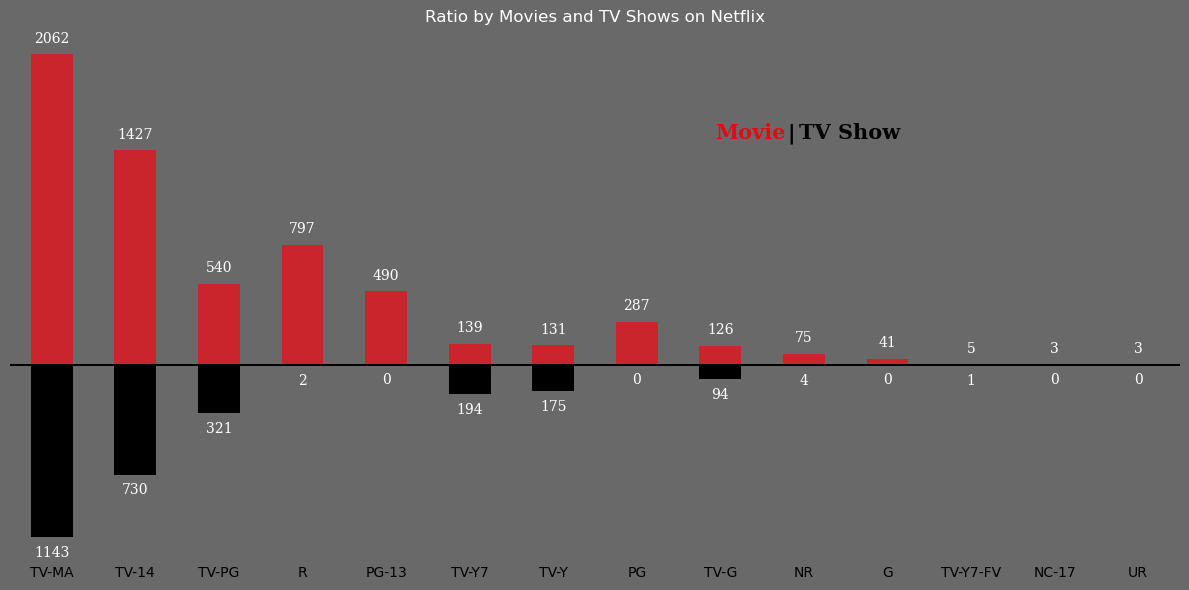

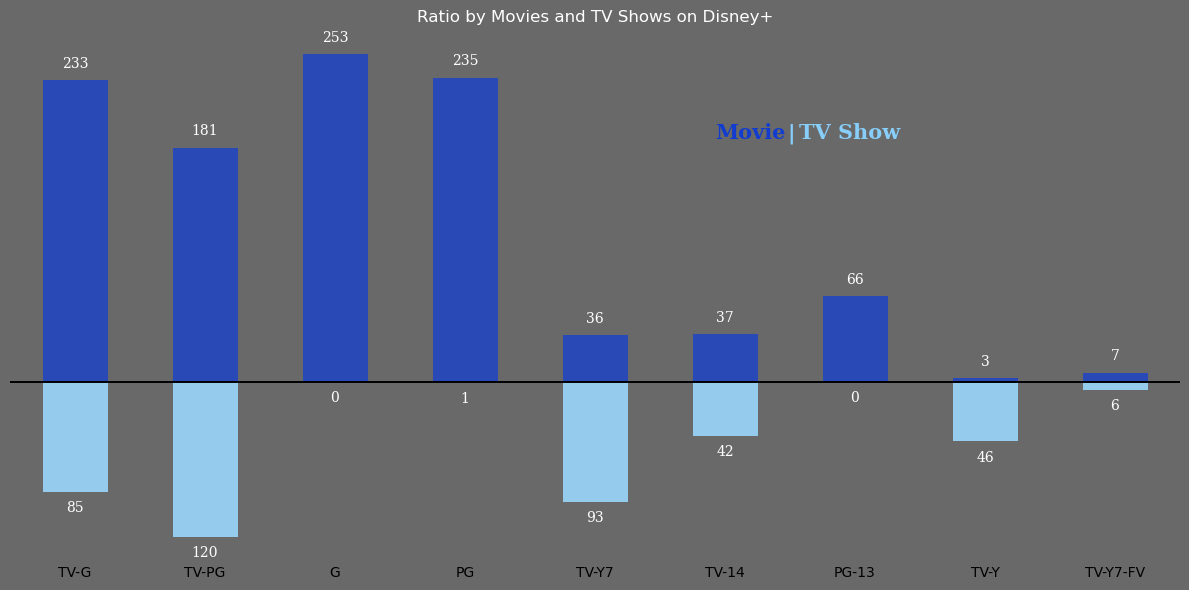

In [416]:
q6_title = ['Ratio by Movies and TV Shows on Netflix', 'Ratio by Movies and TV Shows on Disney+']
ori_list = [net_df, dis_df]
for i, data in enumerate([(netflix_movie, netflix_tv), (disney_movie, disney_tv)]):
    movie, tv = data[0], data[1]
    rate_movie_df = add_miss(ori_list[i], movie.rating.value_counts())
    rate_tv_df = add_miss(ori_list[i], tv.rating.value_counts())
    rate_tv_df = -1 * rate_tv_df

    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    q6_imageSet(rate_movie_df, rate_tv_df, ax, q6_title[i], all_color[i])
    ax.axhline(y = 0, color = 'black', linewidth = 1.4)
    fig.text(0.6, 0.76, 'Movie', fontweight="bold", fontfamily='serif', fontsize=15, color=all_color[i][0])
    fig.text(0.66, 0.76, '|', fontweight="bold", fontfamily='serif', fontsize=15, color=all_color[i][1])
    fig.text(0.67, 0.76, 'TV Show', fontweight="bold", fontfamily='serif', fontsize=15, color=all_color[i][1])

    plt.tight_layout()
    plt.show()

In [408]:
def compute_genre(data):
    data = data.apply(lambda x : x.replace(' ,', ',').replace(', ', ',').split(','))
    table = {}
    for d in list(data):
        if len(d) == 1:
            if d[0] in table: table[d[0]] += 1
            else: table[d[0]] = 1
        else:
            for i in d:
                if i in table: table[i] += 1
                else: table[i] = 1
    df = pd.DataFrame.from_dict(table, orient='index', columns=['cnt'])
    return df.sort_values(by='cnt', ascending=False)[:12]

In [409]:
def q7_pie(data, ax, title):
    ax.set_title(title)
    ax.pie(data.cnt, labels=data.index, wedgeprops={'linewidth':3, 'edgecolor':'w', 'width':0.6}, autopct='%.1f%%')

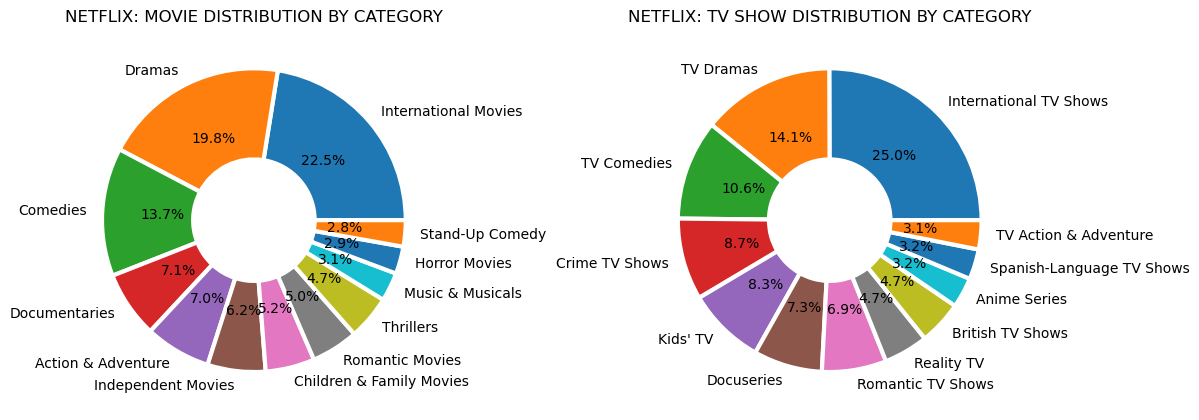

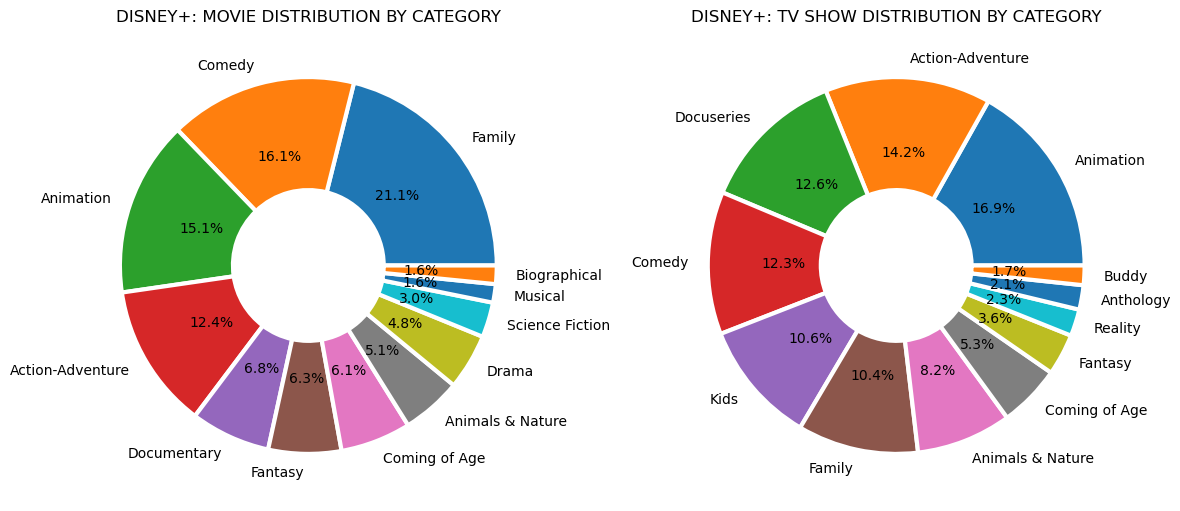

In [433]:
q7_title = [('NETFLIX: MOVIE DISTRIBUTION BY CATEGORY', 'NETFLIX: TV SHOW DISTRIBUTION BY CATEGORY')
           , ('DISNEY+: MOVIE DISTRIBUTION BY CATEGORY', 'DISNEY+: TV SHOW DISTRIBUTION BY CATEGORY')]
for i, data in enumerate([(netflix_movie, netflix_tv), (disney_movie, disney_tv)]):
    movie, tv = data[0], data[1]
    movie_genre = compute_genre(movie['listed_in'])
    tv_genre = compute_genre(tv['listed_in'])

    fig, ax = plt.subplots(1, 2, figsize=(12, 8))
    q7_pie(movie_genre, ax[0], q7_title[i][0])
    q7_pie(tv_genre, ax[1], q7_title[i][1])

    plt.tight_layout()
    plt.show()

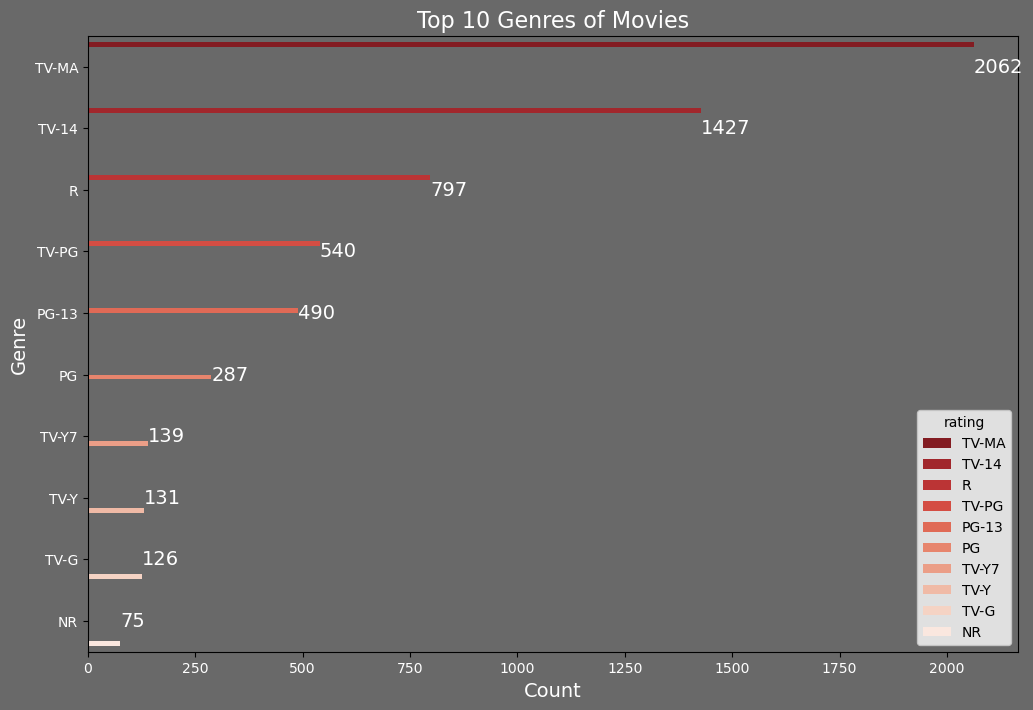

In [424]:
# Extract top 10 movie genres
top10_netflix_movie = netflix_df[netflix_df['type'] == 'Movie']['rating'].value_counts().sort_values(ascending=False).iloc[:10]
# Create a bar plot
plt.figure(figsize=(12, 8), facecolor='#696969')
sns.barplot(x=top10_netflix_movie.values, y=top10_netflix_movie.index, hue=top10_netflix_movie.index, palette='Reds_r')

# Set plot title and axis labels
plt.title('Top 10 Genres of Movies', fontsize=16, color='white')
plt.xlabel('Count', fontsize=14, color='white')
plt.ylabel('Genre', fontsize=14, color='white')
plt.xticks(color='white')
plt.yticks(color='white')
plt.gca().set_facecolor('#696969')
 
# Add data labels to each bar
for i, count in enumerate(top10_netflix_movie):
    plt.text(count, i, str(count), ha='left', va='center', color='white', fontsize=14)
plt.show()

In [418]:
netflix_df.head()

,show_id,type,title,country,date_added,release_year,rating,duration,listed_in,add_year,add_month,main_country
0,s1,Movie,Dick Johnson Is Dead,United States,2021-09-25,2020,PG-13,90 min,Documentaries,2021,9,United States
1,s2,TV Show,Blood & Water,South Africa,2021-09-24,2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries",2021,9,South Africa
2,s3,TV Show,Ganglands,Unknown,2021-09-24,2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",2021,9,Unknown
3,s4,TV Show,Jailbirds New Orleans,Unknown,2021-09-24,2021,TV-MA,1 Season,"Docuseries, Reality TV",2021,9,Unknown
4,s5,TV Show,Kota Factory,India,2021-09-24,2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",2021,9,India


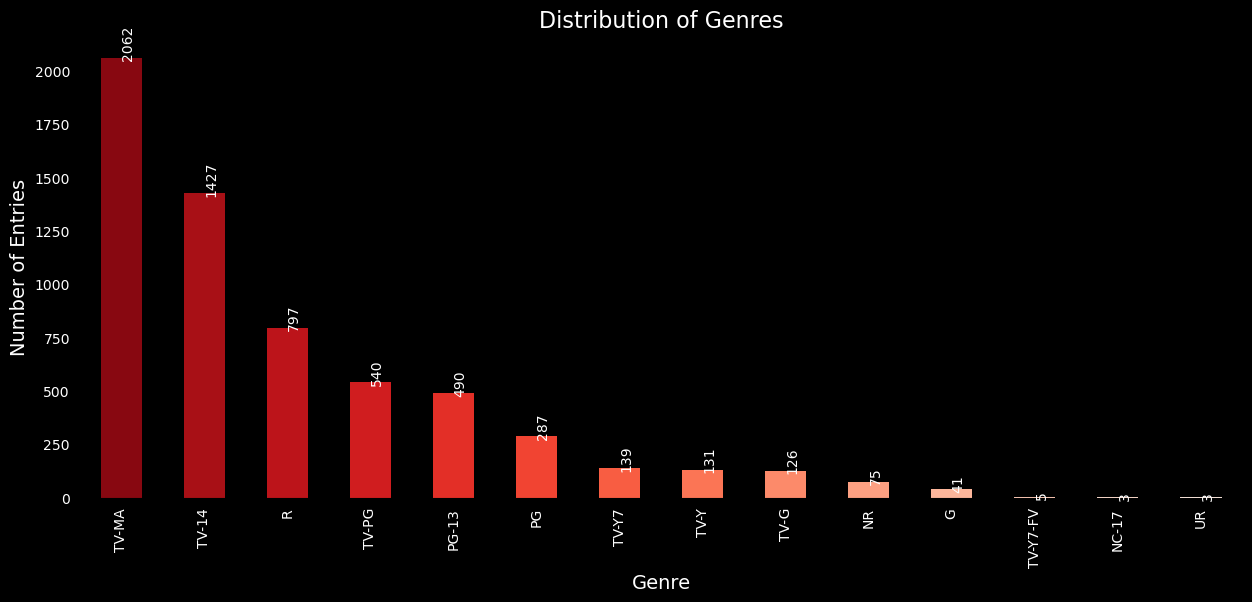

In [438]:

# Group by genre and count the number of entries
genre_movie_df = netflix_movie.groupby('rating').size().sort_values(ascending=False)

# Create a bar plot
plt.figure(figsize=(12, 6), facecolor='black')
genre_movie_df.plot.bar(figsize=(15, 6), color=sns.color_palette("Reds_r", len(genre_movie_df)))
for index, value in enumerate(list(genre_movie_df)):
    plt.text(index, value, str(value), rotation=90, color='white')
plt.title('Distribution of Genres', fontsize=16, color='white')
plt.xlabel('Genre', fontsize=14, color='white')
plt.ylabel('Number of Entries', fontsize=14, color='white')
plt.xticks(rotation=90, color='white')
plt.yticks(color='white')
plt.gca().set_facecolor('black')
plt.show()

In [437]:
print(netflix_movie.info())netflix_movie

<class 'pandas.core.frame.DataFrame'>
Index: 6126 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   show_id       6126 non-null   object        
 1   type          6126 non-null   object        
 2   title         6126 non-null   object        
 3   country       6126 non-null   object        
 4   date_added    6126 non-null   datetime64[ns]
 5   release_year  6126 non-null   int64         
 6   rating        6126 non-null   object        
 7   duration      6126 non-null   object        
 8   listed_in     6126 non-null   object        
 9   add_year      6126 non-null   int32         
 10  add_month     6126 non-null   int32         
 11  main_country  6126 non-null   object        
dtypes: datetime64[ns](1), int32(2), int64(1), object(8)
memory usage: 574.3+ KB
None


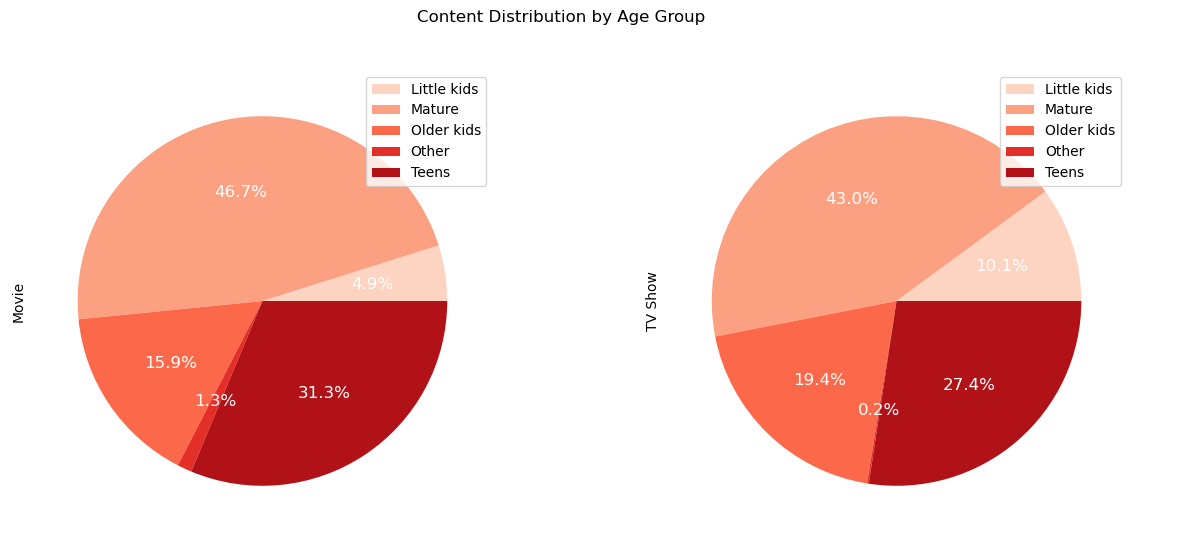

In [440]:
# Define age categories
little_kids = ['G', 'TV-Y', 'TV-G']
older_kids = ['PG', 'TV-Y7', 'TV-Y7-FV', 'TV-PG']
teens = ['PG-13', 'TV-14']
mature = ['R', 'NC-17', 'TV-MA']
rating_list = [little_kids, older_kids, teens, mature]
rating_names = ['Little kids', 'Older kids', 'Teens', 'Mature']


# Filter out rows with missing ratings
df_dup = netflix_df[~netflix_df['rating'].isna()]

# Categorize content into age groups
age_group = np.select([df_dup['rating'].isin(categ) for categ in rating_list], rating_names, 'Other')

# Group data by age group and type (movie/tv show)
df_grouped = df_dup.groupby([age_group, 'type']).size().unstack(fill_value=0)

# Create a pie chart to visualize content distribution by age group
fig, ax = plt.subplots(figsize=(15, 6))
df_grouped.plot.pie(subplots=True, ax=ax, legend=True, autopct='%1.1f%%',
                    textprops={'fontsize': 12, 'color': 'white'},
                    title='Content Distribution by Age Group',
                    colors=sns.color_palette("Reds", n_colors=5))

# Show the plot
plt.show()

In [441]:
df = netflix_df.copy()
df['country'] = df['country'].str.strip(',').str.replace(', ', ',').str.split(',')
df = df.explode('country')
df['category'] = df['category'].str.strip(',').str.replace(', ', ',').str.split(',')
df = df.explode('category')

KeyError: 'category'

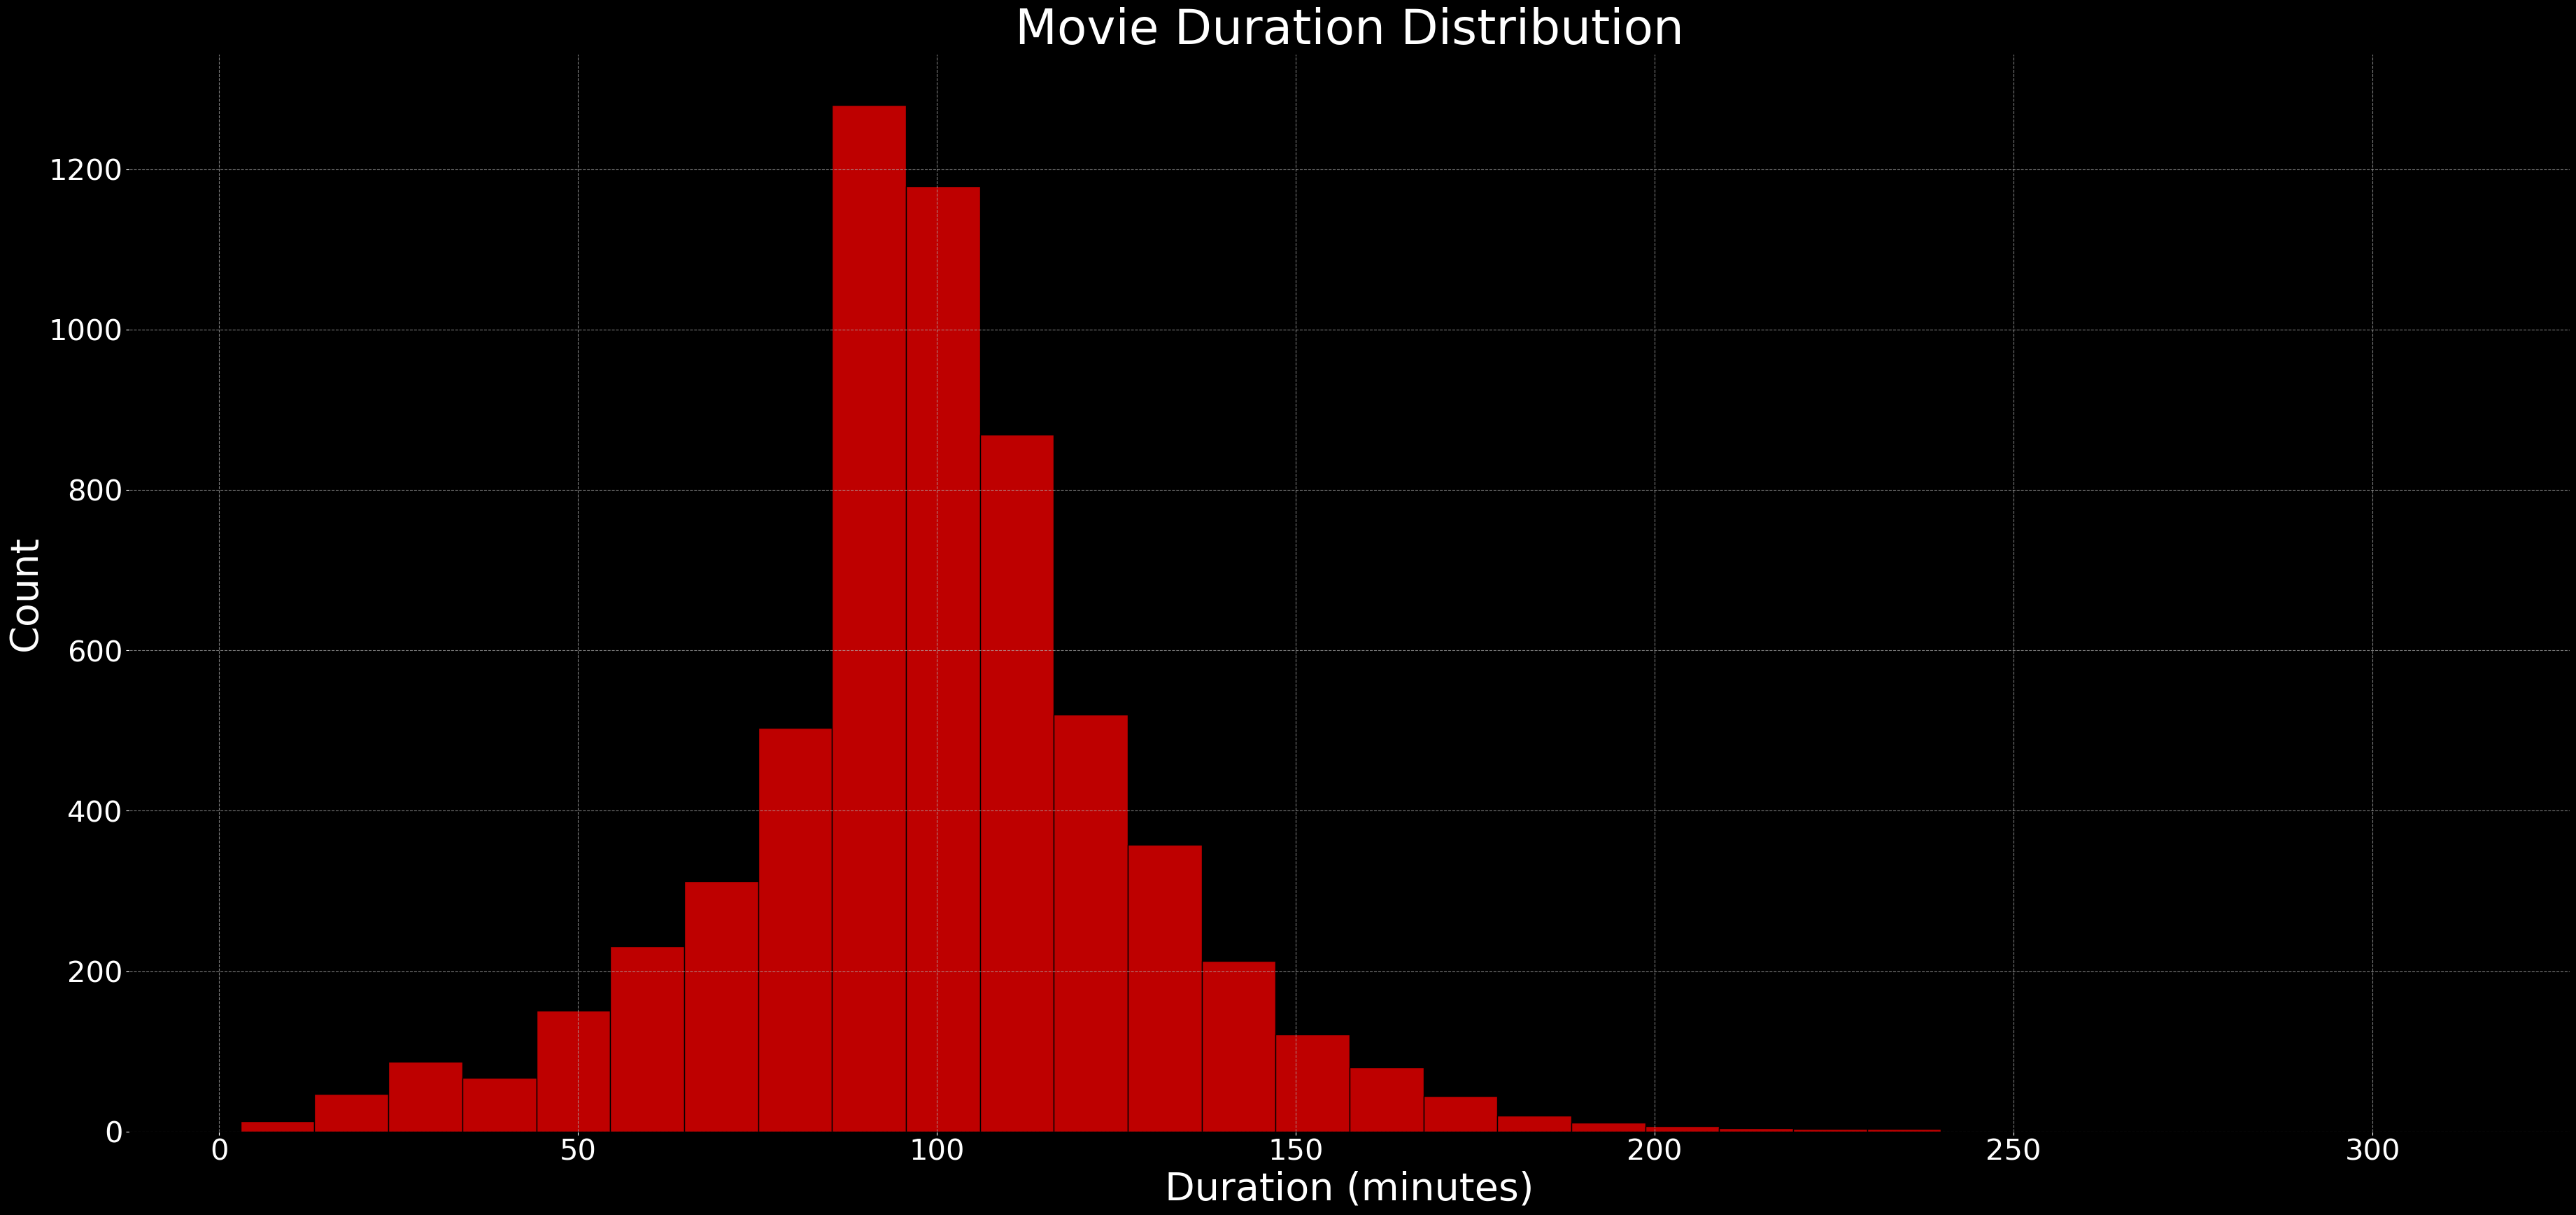

In [442]:
# Filter movies and clean duration data
movie_df = netflix_df[netflix_df['type'] == 'Movie'].copy()
movie_df['duration'] = movie_df['duration'].str.replace("min", "").str.strip()
movie_df['duration'] = movie_df['duration'].astype(int)
movie_df = movie_df[movie_df['duration'] > 1]

# Create histogram for movie duration distribution
plt.figure(figsize=(45, 20), facecolor='black')
ax = sns.histplot(x='duration', data=movie_df, bins=30, color='red')

# Set labels and title
ax.set_xlabel('Duration (minutes)', fontsize=40, color='white')
ax.set_ylabel('Count', fontsize=40, color='white')
ax.tick_params(axis='x', colors='white', labelsize=30)
ax.tick_params(axis='y', colors='white', labelsize=30)
ax.set_title('Movie Duration Distribution', fontsize=50, color='white')
ax.set_facecolor('black')

# Add gridlines
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [443]:
netflix_tv[['duration','title']].sort_values(by='duration', ascending =False).head()

,duration,title
1701,9 Seasons,American Horror Story
1480,9 Seasons,Still Game
8442,9 Seasons,The Office (U.S.)
6504,9 Seasons,Club Friday The Series 6
5803,9 Seasons,Forensic Files


In [444]:
disney_tv[['duration','title']].sort_values(by='duration', ascending =False).head()

,duration,title
553,9 Seasons,America's Funniest Home Videos
125,9 Seasons,Dr. K's Exotic Animal ER
557,8 Seasons,Brain Games
285,8 Seasons,Car SOS
307,7 Seasons,Wicked Tuna: Outer Banks
